In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

# feature engineering from: 
# ProcessCabin.py, processFare.py, ProcessName.py, fill_n_scale.py
# data_processing.py, interaction.py

data = pd.read_csv('dfdf.csv')
test_data = data[data['Survived'].isnull()]
train_data = data[data['Survived'].notnull()]
X_train = train_data.drop('Survived',axis = 1)
X_test = test_data.drop('Survived',axis = 1)
y_train = train_data['Survived']

In [7]:
print(X_test.shape)
print(X_train.shape)

(418, 357)
(891, 357)


# Firstly, try 300+ features from dfdf.csv

We tried 3 different data sets to make a more comprehensive model tuning: 

- Dataset from dfdf.csv
- Dataset from an easier method (no operations between each of the features)
- Dataset from dfdf.csv but drop the Age and Age1 columns

In [8]:
X_train.head()

,Age,Fare_scaled,Fare_bin_id_scaled,SibSp_scaled,Parch_scaled,Embarked_scaled,CabinNumber_scaled,CabinLetter_scaled,Names_scaled,Title_id_scaled,...,Embarked_scaled-CabinNumber_scaled,Embarked_scaled/Pclass_scaled,Embarked_scaled-Pclass_scaled,Embarked_scaled/Title_id_scaled,Embarked_scaled-Title_id_scaled,Embarked_scaled/TicketNumber_scaled,Embarked_scaled-TicketNumber_scaled,Embarked_scaled/CabinLetter_scaled,Embarked_scaled-CabinLetter_scaled,Embarked_scaled*Embarked_scaled
0,22.0,-0.503281,-1.323333,0.481288,-0.445,-0.603436,-0.420654,-0.438679,-0.449489,-0.737684,...,-0.182782,-0.716741,-1.445352,0.818013,0.134249,1.353909,-0.157737,1.375573,-0.164756,0.364135
1,38.0,0.734766,-0.434547,0.481288,-0.445,0.927373,2.843455,0.118827,2.200874,0.319959,...,-1.916082,-0.599815,2.473471,2.898408,0.607414,-2.256688,1.338317,7.804414,0.808546,0.860021
2,26.0,-0.490231,0.454238,-0.479087,-0.445,-0.603436,-0.420654,-0.438679,-0.449489,1.377603,...,-0.182782,-0.716741,-1.445352,-0.438033,-1.981039,1.353891,-0.157731,1.375573,-0.164756,0.364135
3,35.0,0.383203,-0.434547,0.481288,-0.445,-0.603436,4.302704,0.118827,2.200874,0.319959,...,-4.906139,0.390296,0.942662,-1.885975,-0.923395,2.731632,-0.382529,-5.078282,-0.722262,0.364135
4,35.0,-0.487814,0.454238,-0.479087,-0.445,-0.603436,-0.420654,-0.438679,-0.449489,-0.737684,...,-0.182782,-0.716741,-1.445352,0.818013,0.134249,-2.066631,-0.895426,1.375573,-0.164756,0.364135


## 1. Based on X_train data form dfdf.csv; (all features included)

### Filtering the feature

- If features are categorical, calcluate a chi-square statistic between each feature and the target vector.
- If the features are quantitative, compute the ANOVA F-value between each feature and the target vector.

**F-value** scores exmaine if, when we group the numerical feature by the target vector, the means for each group are significantly different. 

The methods based on F-test estimate the degree of linear dependency between two random variables. On the other hand, mutual information methods can capture any kind of statistical dependency, but being nonparametric, they require more samples for accurate estimation.

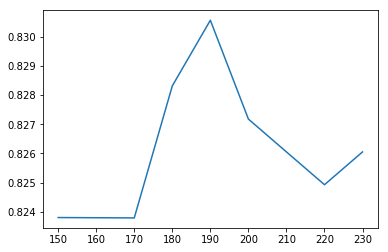

The best cross-validation score is 0.8305578254454659 when n_estimator = 190


In [9]:
# Let's try to find a good estimator to get max cross validation score
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import accuracy_score
def rf_clf(X_train, X_test, 
           params = {'n_estimators':[150, 170, 180, 190, 200 ,220, 230]}):
    scores_ = []
    for n in params['n_estimators']:
        forest = RandomForestClassifier(n_estimators=n,random_state=0,
                                       min_samples_split=4, max_features = 'sqrt')
        forest.fit(X_train, y_train)
        scores = cross_val_score(forest, X_train, y_train, cv=10)
        score = np.average(scores)
        scores_.append(score)
    plt.plot(params['n_estimators'], scores_)
    plt.show()
    print('The best cross-validation score is {0} when n_estimator = {1}'.format(max(scores_), 
                                                                 params['n_estimators'][scores_.index(max(scores_))]))
    n = params['n_estimators'][scores_.index(max(scores_))]
    forest = RandomForestClassifier(n_estimators=n,random_state=0,
                                       min_samples_split=4, max_features = 'sqrt')
    forest.fit(X_train, y_train)
rf_clf(X_train, X_test)

In [58]:
# let's try gridsearchCV
def rf_clf_grid(X_train, X_test, 
                params = {'n_estimators':[1,5,10,20,50, 70,100, 150, 200],
             'min_samples_split':[2,3,4,5,6,7,8,9,10]}):
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(RandomForestClassifier(random_state=0), 
                               params, cv = 5)
    grid_search.fit(X_train, y_train)
    y_predict = grid_search.predict(X_test)
    print('train cv score - ' + str(grid_search.best_score_))
    print('best params are' + str(grid_search.best_params_))
    return grid_search
    #return grid_search
rf_clf_grid(X_train, X_test)

train cv score - 0.83950617284
best params are{'min_samples_split': 7, 'n_estimators': 70}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 20, 50, 70, 100, 150, 200], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### Drop columns with highly correlated data

As our features contain more than 300 features, it's reasonable to check the correlation between each feature and drop the highly correlated ones. 

In [11]:
def df_no_corr(data):
    df_corr=data.drop(['Survived'],axis=1).corr(method='spearman')
    mask=np.ones(df_corr.columns.size)-np.eye(df_corr.columns.size)
    df_corr=df_corr*mask
    drops=[]
    for col in df_corr.columns.values:
        if np.in1d([col],drops):
            continue
        corr=df_corr.index[abs(df_corr[col])>0.9].values
        drops=np.union1d(drops,corr)
    print("\nDropping",drops.shape[0],"highly correlated features")
    data_nocorr=data.drop(drops,axis=1,inplace=False)
    return data_nocorr
print('Shape of new datasets: {}'.format(df_no_corr(data).shape))


Dropping 113 highly correlated features
Shape of new datasets: (1309, 245)


### Try the same model on the modified datasets

In [12]:
data_new = df_no_corr(data)
X_train_new = data_new.iloc[:891,1:]
X_test_new = data_new.iloc[891:,1:]
rf_clf_grid(X_train_new, X_test_new) #the highest score so far
# after data cleaning by correlation


Dropping 113 highly correlated features
train cv score - 0.838383838384
best params are{'min_samples_split': 6, 'n_estimators': 100}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 20, 50, 70, 100, 150, 200], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)


Then we also want to select the SelectKBest features based on f_classif.



In [13]:
from sklearn.feature_selection import SelectKBest, f_classif

def feature_sel2(X, k=100):
    selector = SelectKBest(f_classif, k=k)
    selector.fit(X_train, y_train)
    scores = -np.log10(selector.pvalues_)
    indices = np.argsort(scores)[::-1]
    print("Features importance :")
    #for f in range(len(scores)):
        #print("%0.2f %s" % (scores[indices[f]],X_train.columns[indices[f]]))
    X_new = selector.transform(X)
    return X_new
X_new = feature_sel2(pd.concat([X_train, X_test]))
X_train_new = X_new[:891,:]
X_test_new = X_new[891:,:]
print(X_train_new.shape)

Features importance :
(891, 100)


In [14]:
rf_clf_grid(X_train_new, X_test_new) 

train cv score - 0.838383838384
best params are{'min_samples_split': 6, 'n_estimators': 50}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 20, 50, 70, 100, 150, 200], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### Try SelectFromModel from sklearn

In [15]:
from sklearn.feature_selection import SelectFromModel
def feature_sel(X):
    clf = RandomForestClassifier()
    clf.fit(X.iloc[:891,:], y_train)
    model = SelectFromModel(clf, prefit=True)
    X_new = model.transform(X)
    print(X_new.shape)
    print(model.threshold_)
    return X_new
X_new = feature_sel(pd.concat([X_train, X_test]))
X_train_new = X_new[:891,:]
X_test_new = X_new[891:,:]
rf_clf_grid(X_train_new, X_test_new) 

(1309, 92)
0.00280112044818
train cv score - 0.846240179574
best params are{'min_samples_split': 7, 'n_estimators': 100}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 20, 50, 70, 100, 150, 200], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

### Export our result for stacking

In [349]:
pd.DataFrame(output.predict(X_test_new)).to_csv('rdf.csv')

In [462]:
pd.DataFrame(output.predict(X_train_new)).to_csv('rdf_train.csv')

## Let's try drop the age column

In [350]:
print(X_train.shape)
print(X_test.shape)

(891, 357)
(418, 357)


In [16]:
datasets = [X_train, X_test]
for i in range(2):
    try:
        datasets[i] = datasets[i].drop(['Age', 'Age1'],axis=1)
    except:
        pass
for dataset in datasets:
    print('New data shape')
    print(dataset.shape)

New data shape
(891, 355)
New data shape
(418, 355)


In [17]:
# Let's try the new train data
rf_clf_grid(datasets[0], datasets[1])

train cv score - 0.840628507295
best params are{'min_samples_split': 7, 'n_estimators': 50}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 20, 50, 70, 100, 150, 200], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

## Let's try some other data sources

In [19]:
def kernel_data():
    train_df = pd.read_csv('input/train.csv')
    test_df = pd.read_csv('input/test.csv')
    combine = [train_df, test_df]
    train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
    test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
    
    # Firstly, we extract the Title from Name column: Sir, Madame, Mrs, Doc. etc.
    for dataset in combine:
        dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    
    # Combine unfrequent titles into same categories and numerize the categorical data
    for dataset in combine:
        dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
        'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
        dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
        dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    # map title columns and fill NA rows with 0
    for dataset in combine:
        dataset['Title'] = dataset['Title'].map(title_mapping)
        dataset['Title'] = dataset['Title'].fillna(0)
    # Since Name column and PassengerID columns are quite unique and does not provide much information, we decided to drop them
    train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
    test_df = test_df.drop(['Name'], axis=1)
    combine = [train_df, test_df]
    
    # Numerize the categorical columns ('Sex')
    for dataset in combine:
        dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
    
    # Fill missing ages with median value in the same Sex and PClass
    guess_ages = np.zeros((2,3))
    for dataset in combine:
        for i in range(0, 2):
            for j in range(0, 3):
                guess_df = dataset[(dataset['Sex'] == i) & \
                                      (dataset['Pclass'] == j+1)]['Age'].dropna()
                age_guess = guess_df.median()

                # Convert random age float to nearest .5 age
                guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5

        for i in range(0, 2):
            for j in range(0, 3):
                dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                        'Age'] = guess_ages[i,j]
    dataset['Age'] = dataset['Age'].astype(int)
    
    # bin Age column into 5 and numerize the categorical items
    train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
    for dataset in combine:    
        dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
        dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
        dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
        dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
        dataset.loc[ dataset['Age'] > 64, 'Age']
    train_df = train_df.drop(['AgeBand'], axis=1)
    combine = [train_df, test_df]  
    
    # manually create another column of Family Size
    for dataset in combine:
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    for dataset in combine:
        dataset['IsAlone'] = 0
        dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    # Drop Parch, SibSp and FamilySize
    train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
    test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
    combine = [train_df, test_df]
    
    # Manually create another column
    for dataset in combine:
        dataset['Age*Class'] = dataset.Age * dataset.Pclass
        
    # Fill in NA item in Embarked columns (mode value)
    freq_port = train_df.Embarked.dropna().mode()[0]
    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    for dataset in combine:
        dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Bin Fare column
    test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
    train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
    for dataset in combine:
        dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
        dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
        dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
        dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
        dataset['Fare'] = dataset['Fare'].astype(int)

    # Drop Fare column    
    train_df = train_df.drop(['FareBand'], axis=1)
    train_df.drop('Survived', axis=1, inplace=True)
    test_df.drop('PassengerId', axis=1, inplace = True)
    combine = [train_df, test_df]
    return combine
kaggle = kernel_data()

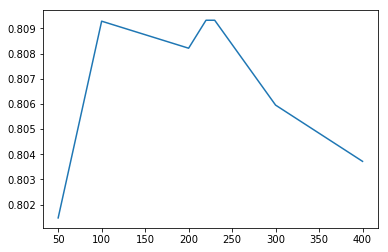

The best cross-validation score is 0.8093221541255249 when n_estimator = 220


In [23]:
rf_clf(kaggle[0], kaggle[1],
       params = {'n_estimators':[50, 100, 200,
                                 220, 230, 300, 400]})

In [21]:
rf_clf_grid(kaggle[0], kaggle[1],
            n_list = [170, 180, 190,200,220, 230,250])

train cv score - 0.81593714927
best params are{'min_samples_split': 5, 'n_estimators': 5}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [1, 5, 10, 20, 50, 70, 100, 150, 200], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

## SVC

In [29]:
def svc_model_grid(X_train, X_test):
    params = {'C': [1, 10, 100, 1000], 
                  'gamma': [0.01,0.1,1,0.001, 0.0001]}
     
    grid_search = GridSearchCV(SVC(random_state=0), params, cv=5)
    grid_search.fit(X_train, y_train)
    print('train score - ' + str(grid_search.best_score_))
    print('best params are' + str(grid_search.best_params_)) 
    #return grid_search
svc_model_grid(kaggle[0], kaggle[1])
svc_model_grid(X_train, X_test)
svc_model_grid(datasets[0],datasets[1])
svc_model_grid(X_train_new, X_test_new)

train score - 0.808080808081
best params are{'C': 100, 'gamma': 0.1}
train score - 0.821548821549
best params are{'C': 1, 'gamma': 0.0001}
train score - 0.822671156004
best params are{'C': 1, 'gamma': 0.0001}
train score - 0.818181818182
best params are{'C': 10, 'gamma': 0.0001}


## KNN

First plot the graph to have an idea where should we test the parameter range

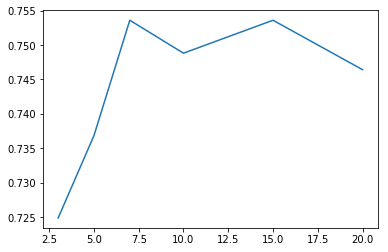

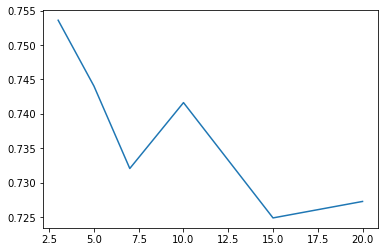

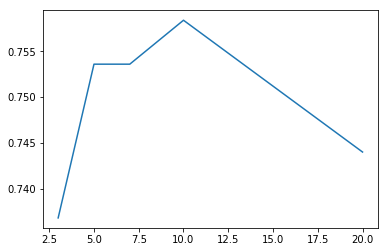

In [250]:
def knn(X_train, X_test):
    n_list = [3,5,7,10,15,20]
    scores = []
    for n in n_list:
        knn = KNeighborsClassifier(n_neighbors=n)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        
        #print('Train accuracy {}'.format(accuracy_score(y_train, 
                                                        #knn.predict(X_train))))
        scores.append(accuracy_score(y_test, knn.predict(X_test)))
        #print('Test accuracy {}'.format(accuracy_score(y_test, y_pred)))
    plt.plot(n_list, scores)
    plt.show()
knn(X_train, X_test)
knn(kaggle[0], kaggle[1])
knn(datasets[0], datasets[1])

In [31]:
def knn_grid(X_train, X_test):
    params = {'n_neighbors':list(np.arange(3,20,2))}
    grid_search = GridSearchCV(KNeighborsClassifier(), params, cv=5)
    grid_search.fit(X_train, y_train)
    print('train score - ' + str(grid_search.best_score_))
    print('best params are' + str(grid_search.best_params_)) 
    return grid_search
knn_grid(X_train, X_test)
knn_grid(kaggle[0], kaggle[1])
knn_grid(datasets[0], datasets[1])
knn_grid(X_train_new, X_test_new)

train score - 0.799102132435
best params are{'n_neighbors': 13}
train score - 0.794612794613
best params are{'n_neighbors': 7}
train score - 0.803591470258
best params are{'n_neighbors': 3}
train score - 0.765432098765
best params are{'n_neighbors': 3}


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Export best result to knn.csv for stacking

In [468]:
output3 = knn_grid(datasets[0], datasets[1])
pd.DataFrame(output3.predict(X_test_new)).to_csv('knn.csv')
pd.DataFrame(output3.predict(X_train_new)).to_csv('knn_train.csv')

train score - 0.781144781145
test score - 0.751196172249
best params are{'n_neighbors': 7}


## DecisionTree

In [32]:
def decision(X_train, X_test):
    decision_tree = DecisionTreeClassifier(max_features='sqrt', random_state=0)
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_test)
    print('Train score is {}'.format(accuracy_score(y_train, 
                                                    decision_tree.predict(X_train))))
    print(np.mean(cross_val_score(decision_tree,X_train, y_train, cv=5)))
    #return y_pred
decision(X_train, X_test)    
decision(kaggle[0], kaggle[1])
decision(datasets[0],datasets[1])
decision(X_train_new,X_test_new)

Train score is 0.9977553310886644
0.773383166885
Train score is 0.8574635241301908
0.798039426382
Train score is 0.9932659932659933
0.768862896382
Train score is 0.9977553310886644
0.756478237541


In [33]:
# Export data
pd.DataFrame(decision(kaggle[0], kaggle[1])).to_csv('DecisionTree.csv')

decision_tree = DecisionTreeClassifier(max_features='sqrt', 
                                       random_state=0)
decision_tree.fit(kaggle[0], y_train)
y_pred = decision_tree.predict(X_train_new)
pd.DataFrame(y_pred).to_csv('DecisionTree_train.csv')

#### I'm not sure it's useful to do a gridsearchcv for Decision Tree

## Logistic Regression

In [260]:
def lr(X_train, X_test):
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print('Train score is {}'.format(lr.score(X_train, y_train)))
    print('Test score is {}'.format(accuracy_score(y_test, y_pred)))
lr(X_train, X_test)
lr(kaggle[0], kaggle[1])
lr(datasets[0], datasets[1])

Train score is 0.9023569023569024
Test score is 0.7583732057416268
Train score is 0.792368125701459
Test score is 0.7631578947368421
Train score is 0.9012345679012346
Test score is 0.7488038277511961


In [34]:
def lr_grid(X_train, X_test):
    params = {'penalty':['l1','l2'],
             'C':[0.01,0.1,1,10]}
    grid_search = GridSearchCV(LogisticRegression(random_state=0), params, cv=5)
    grid_search.fit(X_train, y_train)
    print('train score - ' + str(grid_search.best_score_))
    print('best params are' + str(grid_search.best_params_)) 
    return grid_search
lr_grid(X_train, X_test)
lr_grid(kaggle[0], kaggle[1])
lr_grid(datasets[0], datasets[1])    
lr_grid(X_train_new, X_test_new)

train score - 0.827160493827
best params are{'C': 0.01, 'penalty': 'l2'}
train score - 0.79012345679
best params are{'C': 0.1, 'penalty': 'l1'}
train score - 0.822671156004
best params are{'C': 0.1, 'penalty': 'l1'}
train score - 0.827160493827
best params are{'C': 10, 'penalty': 'l2'}


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
pd.DataFrame(lr_grid(X_train, X_test).predict(X_test)).to_csv('lr.csv')
pd.DataFrame(lr_grid(X_train, X_test).predict(X_train)).to_csv('lr_train.csv')

## New Feature engineering idea

Before submission, we came up with another idea to do feature engineering. And test the data if we can get a better score

In [45]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn import cross_validation
import re
import operator
from sklearn.feature_selection import SelectKBest, f_classif

# import train and test data

train = pd.read_csv("input/train.csv", dtype={"Age": np.float64}, )
test = pd.read_csv("input/test.csv", dtype={"Age": np.float64}, )

target = train["Survived"].values
full = pd.concat([train, test])

# split title from surname

full['surname'] = full["Name"].apply(lambda x: x.split(',')[0].lower())

# numerize the categorical data

full["Title"] = full["Name"].apply(lambda x: re.search(' ([A-Za-z]+)\.',x).group(1))
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Dr": 5, "Rev": 6, "Major": 7, 
                 "Col": 7, "Mlle": 2, "Mme": 3,"Don": 9,"Dona": 9, "Lady": 10, "Countess": 10, "Jonkheer": 10, "Sir": 9, "Capt": 7, "Ms": 2}
full["TitleCat"] = full.loc[:,'Title'].map(title_mapping)

# create a feature called FamilySize

full["FamilySize"] = full["SibSp"] + full["Parch"] + 1
full["FamilySize"] = pd.cut(full["FamilySize"], bins=[0,1,4,20], labels=[0,1,2])

# create a new feature called NameLength

full["NameLength"] = full["Name"].apply(lambda x: len(x))

full["Embarked"] = pd.Categorical.from_array(full.Embarked).codes

# fill in Fare value for test_set using median fare of the corresponding class (8.05 pounds)

full["Fare"] = full["Fare"].fillna(8.05)

# create dummy variables for Sex
full = pd.concat([full,pd.get_dummies(full['Sex'])],axis=1)

full['CabinCat'] = pd.Categorical.from_array(full.Cabin.fillna('0').apply(lambda x: x[0])).codes

# function to get oven/odd/null from cabine 
def get_type_cabine(cabine):
    # Use a regular expression to search for a title. 
    cabine_search = re.search('\d+', cabine)
    # If the title exists, extract and return it.
    if cabine_search:
        num = cabine_search.group(0)
        if np.float64(num) % 2 == 0:
            return '2'
        else:
            return '1'
    return '0'
full["Cabin"] = full["Cabin"].fillna(" ")

full["CabinType"] = full["Cabin"].apply(get_type_cabine)
#print(pd.value_counts(full["CabinType"]))

#### CHILD/FEMALE ADULT/MALE ADULT------------------------------------------------------------
child_age = 18
def get_person(passenger):
    age, sex = passenger
    if (age < child_age):
        return 'child'
    elif (sex == 'female'):
        return 'female_adult'
    else:
        return 'male_adult'
full = pd.concat([full, pd.DataFrame(full[['Age', 'Sex']].apply(get_person, axis=1), columns=['person'])],axis=1)
full = pd.concat([full,pd.get_dummies(full['person'])],axis=1)

### FEATURES BASED ON TICKET   --------------------------------------------------------
table_ticket = pd.DataFrame(full["Ticket"].value_counts())
table_ticket.rename(columns={'Ticket':'Ticket_Members'}, inplace=True)

table_ticket['Ticket_perishing_women'] = full.Ticket[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_ticket['Ticket_perishing_women'] = table_ticket['Ticket_perishing_women'].fillna(0)
table_ticket['Ticket_perishing_women'][table_ticket['Ticket_perishing_women'] > 0] = 1.0 

table_ticket['Ticket_surviving_men'] = full.Ticket[(full.male_adult == 1.0) 
                                    & (full.Survived == 1.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_ticket['Ticket_surviving_men'] = table_ticket['Ticket_surviving_men'].fillna(0)
table_ticket['Ticket_surviving_men'][table_ticket['Ticket_surviving_men'] > 0] = 1.0 

table_ticket["Ticket_Id"]= pd.Categorical.from_array(table_ticket.index).codes
# compress under 3 members into one code.
table_ticket["Ticket_Id"][table_ticket["Ticket_Members"] < 3 ] = -1
table_ticket["Ticket_Members"] = pd.cut(table_ticket["Ticket_Members"], bins=[0,1,4,20], labels=[0,1,2])

full = pd.merge(full, table_ticket, left_on="Ticket",right_index=True,how='left', sort=False)

### FEATURES BASED ON SURNAME    --------------------------------------------------------
table_surname = pd.DataFrame(full["surname"].value_counts())
table_surname.rename(columns={'surname':'Surname_Members'}, inplace=True)

table_surname['Surname_perishing_women'] = full.surname[(full.female_adult == 1.0) 
                                    & (full.Survived == 0.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_surname['Surname_perishing_women'] = table_surname['Surname_perishing_women'].fillna(0)
table_surname['Surname_perishing_women'][table_surname['Surname_perishing_women'] > 0] = 1.0 

table_surname['Surname_surviving_men'] = full.surname[(full.male_adult == 1.0) 
                                    & (full.Survived == 1.0) 
                                    & ((full.Parch > 0) | (full.SibSp > 0))].value_counts()
table_surname['Surname_surviving_men'] = table_surname['Surname_surviving_men'].fillna(0)
table_surname['Surname_surviving_men'][table_surname['Surname_surviving_men'] > 0] = 1.0 

table_surname["Surname_Id"]= pd.Categorical.from_array(table_surname.index).codes
# compress under 3 members into one code.
table_surname["Surname_Id"][table_surname["Surname_Members"] < 3 ] = -1

table_surname["Surname_Members"] = pd.cut(table_surname["Surname_Members"], bins=[0,1,4,20], labels=[0,1,2])

full = pd.merge(full, table_surname, left_on="surname",right_index=True,how='left', sort=False)

### AGE PROCESSING --------------------------------------------------------------------------
classers = ['Fare','Parch','Pclass','SibSp','TitleCat', 
'CabinCat','female','male', 'Embarked', 'FamilySize', 'NameLength','Ticket_Members','Ticket_Id']
etr = ExtraTreesRegressor(n_estimators=200)
X_train = full[classers][full['Age'].notnull()]
Y_train = full['Age'][full['Age'].notnull()]
X_test = full[classers][full['Age'].isnull()]
etr.fit(X_train,np.ravel(Y_train))
age_preds = etr.predict(X_test)
full['Age'][full['Age'].isnull()] = age_preds

train = full[0:891].copy()
test = full[891:].copy()

train = train.drop(['Cabin','Name','Sex','surname','Title','person','Ticket','Survived'],axis=1)
test = test.drop(['Cabin','Name','Sex','surname','Title','person','Ticket','Survived'],axis=1)

### TRAIN THE DATA --------------------------------------------------------------------------

rfc = RandomForestClassifier(n_estimators=3000, 
                             min_samples_split=4)
rfc.fit(train, target)
predictions = rfc.predict(test)

D:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
D:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: Categorical.from_array is deprecated, use Categorical instead
D:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Users\ThinkPad\Anaconda3\lib\site-packages\ipykernel_launcher.py:94: FutureWarning: Categorical.from_array is deprecated, use C

In [59]:
rf_clf_grid(train, test, params={'n_estimators':[2000,2500,3000]})

train cv score - 0.888888888889
best params are{'n_estimators': 2000}


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [2000, 2500, 3000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [556]:
pd.DataFrame(predictions).to_csv('rdf_2.csv')
pd.DataFrame(rfc.predict(train)).to_csv('rdf_2_train.csv')

## Summary

### RandomForest

- Best cv train score is **0.888888888889**
- Data source: new feature engineering idea (see above)
- params = {'min_samples_split': 7, 'n_estimators': 50}

### SVM

- Best cv train score: **0.822671156004**
- Data source: datasets[0], datasets[1] (Data from dfdf.csv, drop ['Age'], ['Age1'])
- params =  {'C': 1, 'gamma': 0.0001}

### KNN

- Best cv train score: **0.803591470258**
- Data source: datasets[0], datasets[1] (Data from dfdf.csv, drop ['Age'], ['Age1'])
- params = {'n_neighbors': 3}

### Decision Tree

- Best cv train score: **0.798039426382**
- Data Source: kaggle[0], kaggle[1] (Data from Kaggle Kernel)
- params = max_features:'sqrt'

### Logistic Regression

- Best cv train score: **0.827160493827**
- Data source: train_data_new, test_data_new (Data from dfdf.csv after SelectFromModel method)
- params = {'C': 10, 'penalty': 'l2'}



